In [2]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = "/content/drive/MyDrive/Shop DataSet.zip"
extract_path = "/content/Shop_Dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction Done!")
print("📁 Extracted files:", os.listdir(extract_path)[:10])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Extraction Done!
📁 Extracted files: ['Shop DataSet']


In [3]:
import os

data_dir = "/content/Shop_Dataset/Shop DataSet"

for root, dirs, _ in os.walk(data_dir):
    print(f"📁 Folder: {root}")
    print(f"📂 Subfolders: {dirs}")
    print("-" * 60)
    break


📁 Folder: /content/Shop_Dataset/Shop DataSet
📂 Subfolders: ['shop lifters', 'non shop lifters']
------------------------------------------------------------


In [4]:
import cv2
import numpy as np

def load_video_frames(video_path, max_frames=16, resize=(112, 112)):
    frames = []
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_interval = max(1, total_frames // max_frames)

    for i in range(0, total_frames, frame_interval):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, resize)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
        if len(frames) >= max_frames:
            break
    cap.release()
    return np.array(frames)

sample_folder = os.path.join(data_dir, "shop lifters")
sample_video = os.path.join(sample_folder, os.listdir(sample_folder)[0])

frames = load_video_frames(sample_video, max_frames=16)
print("🎞️ Frames shape:", frames.shape)


🎞️ Frames shape: (16, 112, 112, 3)


In [5]:
import numpy as np

def load_dataset(base_dir, max_frames=16, resize=(112, 112)):
    X, y = [], []
    classes = ["non shop lifters", "shop lifters"]

    for label, cls in enumerate(classes):
        folder_path = os.path.join(base_dir, cls)
        videos = os.listdir(folder_path)
        print(f"📂 Loading {cls} ... ({len(videos)} videos)")

        for vid in videos:
            video_path = os.path.join(folder_path, vid)
            frames = load_video_frames(video_path, max_frames=max_frames, resize=resize)
            if frames.shape[0] == max_frames:
                X.append(frames)
                y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = load_dataset(data_dir)
print("✅ Dataset loaded successfully!")
print("🧩 X shape:", X.shape)
print("🏷️ y shape:", y.shape)
print("Classes:", np.unique(y))


📂 Loading non shop lifters ... (531 videos)
📂 Loading shop lifters ... (324 videos)
✅ Dataset loaded successfully!
🧩 X shape: (855, 16, 112, 112, 3)
🏷️ y shape: (855,)
Classes: [0 1]


In [6]:
from sklearn.model_selection import train_test_split

X = X.astype("float32") / 255.0

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("✅ Data preprocessing done!")
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


✅ Data preprocessing done!
Train shape: (684, 16, 112, 112, 3)
Test shape: (171, 16, 112, 112, 3)


In [ ]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.utils import shuffle

# إنشاء مولد بيانات للتوسيع
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

# تطبيق الـ augmentation على كل frame داخل الفيديوهات
X_train_aug = []
for video in X_train:
    aug_frames = []
    for frame in video:
        frame = datagen.random_transform(frame)  # augment كل frame
        aug_frames.append(frame)
    X_train_aug.append(np.array(aug_frames))

X_train_aug = np.array(X_train_aug)

# Shuffle البيانات
X_train_aug, y_train = shuffle(X_train_aug, y_train, random_state=42)

print("✅ Augmentation and shuffle applied!")
print(f"Train shape after augmentation: {X_train_aug.shape}")


In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv3D(32, (3,3,3), activation='relu', input_shape=(16,112,112,3)),
    layers.MaxPooling3D((1,2,2)),

    layers.Conv3D(64, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),

    layers.Conv3D(128, (3,3,3), activation='relu'),
    layers.MaxPooling3D((2,2,2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 14, 110, 110,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 14, 55, 55, 32) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 12, 53, 53, 64) │        55,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 26, 26, 64)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 4, 24, 24, 128) │       221,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 2, 12, 12, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,998,145 (19.07 MB)

 Trainable params: 4,998,145 (19.07 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "best_3dcnn_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

history = model.fit(
    X_train_aug, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=8,
    callbacks=[checkpoint],
    verbose=1
)


Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 183ms/step - accuracy: 0.6214 - loss: 0.6684 - val_accuracy: 0.8596 - val_loss: 0.3700
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 0.8649 - loss: 0.3032 - val_accuracy: 0.9006 - val_loss: 0.1814
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9566 - loss: 0.1165 - val_accuracy: 0.9298 - val_loss: 0.1366
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.9734 - loss: 0.0833 - val_accuracy: 0.9766 - val_loss: 0.0571
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9671 - loss: 0.0578 - val_accuracy: 0.9942 - val_loss: 0.0113
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9867 - loss: 0.0384 - val_accuracy: 1.0000 - val_loss: 0.0016
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.0012
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step - accuracy: 1.0000 - loss: 7.9708e-04 - val_accuracy: 1.0

In [10]:
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"✅ Test Loss: {loss:.4f}")
print(f"✅ Test Accuracy: {accuracy:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 1.0000 - loss: 3.7383e-06
✅ Test Loss: 0.0000
✅ Test Accuracy: 1.0000


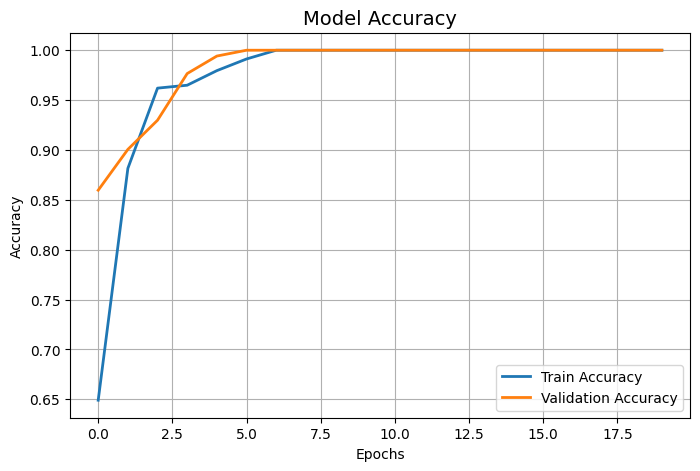

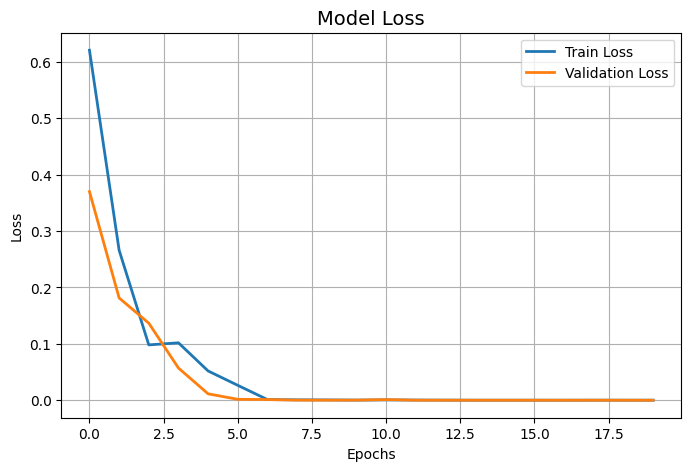

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss", fontsize=14)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 491ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       106
           1       1.00      1.00      1.00        65

    accuracy                           1.00       171
   macro avg       1.00      1.00      1.00       171
weighted avg       1.00      1.00      1.00       171



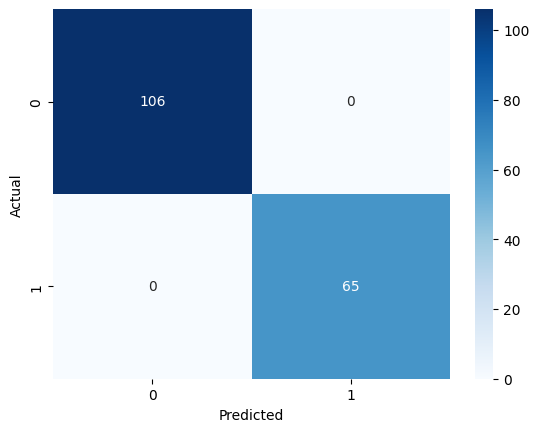

In [9]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

best_model = load_model("best_3dcnn_model.keras")

y_pred = (best_model.predict(X_test) > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model

model = load_model("best_3dcnn_model.keras")


In [16]:
def preprocess_video(video_path, frame_count=16, target_size=(112, 112)):
    cap = cv2.VideoCapture(video_path)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_indices = np.linspace(0, total_frames-1, frame_count, dtype=int)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue
        frame = cv2.resize(frame, target_size)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

    cap.release()

    frames = np.array(frames)
    frames = frames / 255.0  # Normalize
    return frames


In [17]:
def predict_video(video_path):
    frames = preprocess_video(video_path)
    if frames.shape[0] < 16:
        print("⚠️ The video is too short, try with a longer video.")
        return

    X = np.expand_dims(frames, axis=0)  # (1, 16, 112, 112, 3)
    prediction = model.predict(X)
    label = int(prediction[0][0] > 0.5)

    classes = ["🧍‍♂️ Non Shop Lifter", "🕵️‍♂️ Shop Lifter"]
    print(f"🎯 Prediction: {classes[label]} (score={prediction[0][0]:.4f})")


    first_frame = frames[0]
    plt.imshow(first_frame)
    plt.title(classes[label])
    plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
🎯 Prediction: 🕵️‍♂️ Shop Lifter (score=1.0000)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128373 (\N{SLEUTH OR SPY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


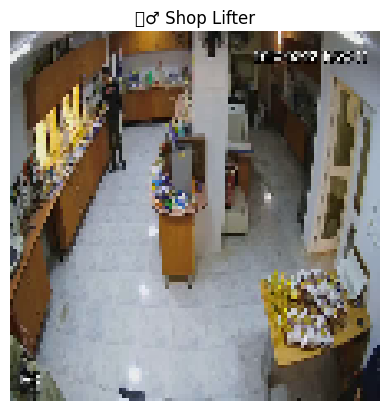

In [19]:
video_path = "/content/Shop_Dataset/Shop DataSet/shop lifters/shop_lifter_100.mp4"
predict_video(video_path)
